In [1]:
#initial version
#created on 25.11.2020 by kaarel
#Idea to train and predict every SOURCE_KEY separately and build window features

import pandas as pd
import xgboost as xgb
from xgboost import plot_importance, plot_tree, XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

train_data = pd.read_csv('../Data/Train_Plant2_added_features.csv')


In [4]:
#Some features Inspired by https://www.kaggle.com/furiousx7/xgboost-time-series
def create_features(in_data):
    in_data['DATE_TIME'] = pd.to_datetime(in_data['DATE_TIME'])
    in_data["DATE"] = in_data['DATE_TIME'].dt.date
    in_data["HOUR"] = in_data['DATE_TIME'].dt.hour
    in_data["MINUTE"] = in_data['DATE_TIME'].dt.minute
    in_data["DAY_OF_YEAR"] = in_data['DATE_TIME'].dt.dayofyear
    in_data["DAY_OF_WEEK"] = in_data['DATE_TIME'].dt.dayofweek
    in_data["MONTH"] = in_data['DATE_TIME'].dt.month
    in_data["DAY_OF_MONTH"] = in_data['DATE_TIME'].dt.day


train_columns = [
       'HOUR',
       'MINUTE',
       'DAY_OF_YEAR',
       'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1',
       'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1',
       'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1',
       'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1',
       'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3',
       'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3',
       'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3',
       'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3',
       'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_3']


In [21]:
#
create_features(train_data)
#split_date = pd.to_datetime('06-01-2020')
#pred_train = train_data.loc[train_data.DATE <= split_date].copy()
#pred_test = train_data.loc[train_data.DATE > split_date].copy()

pred_train, pred_test, train_y, test_y = train_test_split(train_data[train_columns], train_data['DC_POWER'])

In [27]:
import numpy as np
predict_column = 'DC_POWER'
prediction_models = []
reg = xgb.XGBRegressor(n_estimators=10000)
reg.fit(pred_train, train_y,
        eval_set=[(pred_train, train_y), (pred_test, test_y)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=True)
prediction_models.append(reg)

[0]	validation_0-rmse:357.84839	validation_1-rmse:360.02322
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:299.32977	validation_1-rmse:301.16940
[2]	validation_0-rmse:263.69919	validation_1-rmse:266.31259
[3]	validation_0-rmse:242.25378	validation_1-rmse:246.56114
[4]	validation_0-rmse:230.99649	validation_1-rmse:235.69241
[5]	validation_0-rmse:222.22577	validation_1-rmse:227.65668
[6]	validation_0-rmse:217.32201	validation_1-rmse:223.66713
[7]	validation_0-rmse:210.91055	validation_1-rmse:218.25200
[8]	validation_0-rmse:208.26724	validation_1-rmse:215.79916
[9]	validation_0-rmse:205.70126	validation_1-rmse:214.13135
[10]	validation_0-rmse:202.82958	validation_1-rmse:211.95413
[11]	validation_0-rmse:200.90247	validation_1-rmse:210.75595
[12]	validation_0-rmse:199.26349	validation_1-rmse:209.72189
[13]	validation_0-rmse:197.82400	validation_1-rmse:209.495

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

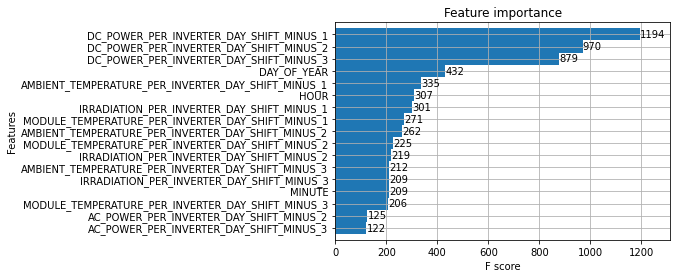

In [28]:
xgb.plot_importance(reg, height=1)


In [33]:
#Features selection try all combinations in a set and choose best set
from itertools import combinations
def get_feature_set_rmse(train_columns):
    k = len(train_columns)-1
    print(k)
    new_train_columns = list(combinations(train_columns,k))
    prediction_models = []
    for t in new_train_columns:
        reg = xgb.XGBRegressor(n_estimators=10000)
        reg.fit(pred_train[np.asarray(t)], train_y,
            eval_set=[(pred_train[np.asarray(t)], train_y), (pred_test[np.asarray(t)], test_y)],
            early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
            verbose=False)
        test_predictions = reg.predict(pred_test[np.asarray(t)])
        RMSE = mean_squared_error(test_y, test_predictions)
        prediction_models.append(RMSE)
        print(RMSE, t)
    return (prediction_models, new_train_columns)


In [34]:
best_models = []
initial_columns = train_columns.copy()
for k in np.arange(len(initial_columns),1,-1):
    (prediction_models, new_train_columns) = get_feature_set_rmse(initial_columns)
    current_loop_best = np.argmin(prediction_models)
    best_models.append((prediction_models[current_loop_best], new_train_columns[current_loop_best]))
    initial_columns = new_train_columns[current_loop_best]
    print('BEST:',prediction_models[current_loop_best],new_train_columns[current_loop_best])

16
39622.22787496385 ('HOUR', 'MINUTE', 'DAY_OF_YEAR', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_2', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3', 'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3')
39453.24835118343 ('HOUR', 'MINUTE', 'DAY_OF_YEAR', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AC_POWER_PER_INVERTER_DAY

In [14]:
#FINDING BETTER HYPERPARAMETERS

train_data = pd.read_csv('../Data/Train_Plant2_added_features.csv')
create_features(train_data)

#BEST 2 plant model
model_train_columns = ['HOUR', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_2', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_3']

#### Create X and Y training data here.....
X = train_data[model_train_columns]
Y = train_data[predict_column]


#https://www.kaggle.com/jayatou/xgbregressor-with-gridsearchcv
# Various hyper-parameters to tune
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #best set identified
              'objective':['reg:linear'],
              'learning_rate': [.01],
              'max_depth': [7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X,
         Y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)




Fitting 2 folds for each of 24 candidates, totalling 48 fits
[21:35:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[21:35:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:36:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
0.5305648339227007
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  9.2min finished


In [35]:
from calculate_model_statistics import calculate_RMSE_MSE


#PERFORMANCE VALIDATION ON TEST DATA
train_data = pd.read_csv('../Data/Train_Plant2_added_features.csv')
test_data = pd.read_csv('../Data/Test_Plant2_added_features.csv')
#BEST 1 plant model
#model_train_columns = ['HOUR', 'MINUTE', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_3']

#BEST 2 plant model
model_train_columns = ['HOUR', 'DAY_OF_YEAR', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_2', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3', 'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3']

#DO DATA PREP FOR TRAIN
create_features(train_data)
pred_train, pred_test, train_y, test_y = train_test_split(train_data[train_columns], train_data['DC_POWER'])

#TRAIN BEST MODEL AGAIN
reg_final = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.01, max_depth =  7, min_child_weight =  4, n_estimators = 500, nthread =  4, objective = 'reg:linear', subsample = 0.7)
reg_final.fit(pred_train[model_train_columns], train_y,
        eval_set=[(pred_train[model_train_columns], train_y), (pred_test[model_train_columns], test_y)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=True)

#CREATE TEST_DATA FEATURES
create_features(test_data)

#DO TEST DATA PREDICTIONS
test_predictions = reg_final.predict(test_data[model_train_columns])

#INDIVIDUAL PERIODS PREDICTIONS
calculate_RMSE_MSE(test_data, predict_column, test_predictions)

[22:28:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:452.40097	validation_1-rmse:445.48541
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:449.15933	validation_1-rmse:442.31943
[2]	validation_0-rmse:445.85071	validation_1-rmse:439.04199
[3]	validation_0-rmse:442.54523	validation_1-rmse:435.77908
[4]	validation_0-rmse:439.42630	validation_1-rmse:432.71283
[5]	validation_0-rmse:436.32132	validation_1-rmse:429.66489
[6]	validation_0-rmse:433.33350	validation_1-rmse:426.75769
[7]	validation_0-rmse:430.22693	validation_1-rmse:423.67432
[8]	validation_0-rmse:427.35785	validation_1-rmse:420.85996
[9]	validation_0-rmse:424.27445	validation_1-rmse:417.81003
[10]	validation_0-rmse:421.32748	validation_1-rmse:414.91553
[11

In [36]:
from calculate_model_statistics import calculate_RMSE_MSE


#PERFORMANCE VALIDATION ON TEST DATA
train_data = pd.read_csv('../Data/Train_Plant2_added_features_standardized.csv')
test_data = pd.read_csv('../Data/Test_Plant2_added_features_standardized.csv')
#BEST 1 plant model
#model_train_columns = ['HOUR', 'MINUTE', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_3']

#BEST 2 plant model
model_train_columns = ['HOUR', 'DAY_OF_YEAR', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_2', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3', 'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3']

#DO DATA PREP FOR TRAIN
create_features(train_data)
pred_train, pred_test, train_y, test_y = train_test_split(train_data[train_columns], train_data['DC_POWER'])

#TRAIN BEST MODEL AGAIN
reg_final = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.01, max_depth =  7, min_child_weight =  4, n_estimators = 500, nthread =  4, objective = 'reg:linear', subsample = 0.7)
reg_final.fit(pred_train[model_train_columns], train_y,
        eval_set=[(pred_train[model_train_columns], train_y), (pred_test[model_train_columns], test_y)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=True)

#CREATE TEST_DATA FEATURES
create_features(test_data)

#DO TEST DATA PREDICTIONS
test_predictions = reg_final.predict(test_data[model_train_columns])

#INDIVIDUAL PERIODS PREDICTIONS
calculate_RMSE_MSE(test_data, predict_column, test_predictions)


[23:07:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:449.79681	validation_1-rmse:453.38007
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:446.53482	validation_1-rmse:450.18631
[2]	validation_0-rmse:443.25290	validation_1-rmse:446.93161
[3]	validation_0-rmse:439.97208	validation_1-rmse:443.71286
[4]	validation_0-rmse:436.86041	validation_1-rmse:440.63117
[5]	validation_0-rmse:433.76163	validation_1-rmse:437.57428
[6]	validation_0-rmse:430.82883	validation_1-rmse:434.66739
[7]	validation_0-rmse:427.66116	validation_1-rmse:431.55277
[8]	validation_0-rmse:424.77106	validation_1-rmse:428.67004
[9]	validation_0-rmse:421.71509	validation_1-rmse:425.62750
[10]	validation_0-rmse:418.79285	validation_1-rmse:422.74341
[11